 # Title
 
 
 #### By Chris Jung, Grace(replace with full name),Haonan Su
 
 ## Background and Motivation
***Heart disease*** is the leading cause of death for men, women, and people of most racial and ethnic groups in most of the countries in the world, even in the countries with developed medical technology such as the United States. About 659,000 people in the US die from heart disease each year, which accounts for 1 in every 4 deaths. It costs the United States about $363 billion each year from 2016 to 2017 [[1]](https://www.who.int/health-topics/cardiovascular-diseases).
The US CDC(Centers for Disease Control and Prevention) suggests maintaining low blood pressure and cholesterol to lower the risk of heart disease [[2]](https://www.cdc.gov/heartdisease/prevention.htm).
For these reasons, we would like to raise awareness of heart disease and its prevention by analyzing the effect of maintaining low blood pressure and cholesterol on heart disease.

## Project Goal
- We are going to use actual medical records from the Cleveland Clinic Foundation to make a sampling distribution using bootstrapping sampling.
- Then we will formulate hypotheses to test if people with low/high blood pressure and cholesterol level have different heart disease rete.
- Finally, we will conduct hypotheses tests to determine if the rate of heart disease is dependent on those two factors.
- By doing these activities, we hope to answer this question:

##### Do people with low blood pressure/cholesterol level have lower chance of developing heart disease?


## Data
- The dataset is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).
- Each observation contains 14 attributes of **a person's medical information** including the presence of heart disease.
- The response variable is the attribute "Class" which represents the presence of heart disease in 5 different categories.
- The explanatory variables are the attribute "trestpbs"(blood pressure), and "chol"(cholesterol).
- The detailed descriptions of the response variable and the two explanatory variables are:
    1. *class*: presence of heart disease. integer valued from 0 (no presence) to 4
    2. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    3. chol: serum cholestoral in mg/dl
    

In [3]:
#loads the libraries
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
source("tests_tutorial_04.R")

#sets the seed for random events such as splitting the data
set.seed(1)

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests_tutorial_04.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


## Reading and Wrangling the Data

In [117]:
#reads in the data table with the 14 attributes
heart_data_0 <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
              col_names = FALSE) %>%
              mutate(X12 = as.numeric(X12), X13 = as.numeric(X13))

#outputs the first 6 rows of the data frame
head(heart_data_0)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


As these columns are separated by commas, we use `read_csv` to read the file from the web. As well, we notice that columns X12 and X13 are treated as characters, not numbers, so we use the `as.numeric` function to change the data type.

In [131]:
#renames the columns
colnames(heart_data_0) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak",
                          "slope", "ca", "thal", "Class")

#selects the 2 attributes that will be used as well as the class
heart_data_1 <- heart_data_0%>%
select(trestbps, chol,  Class)

#We identify patients with trestbps data higher than XXX as having high resting blood pressure and indicate 
#this result with "HIGH" (and vice versa with "NORMAL"), 
#while changing the data type from numeric to factor


#########Due to the unknown problem 94 cannot be assigned to the correct category, 
#########here we discard the two data for trestbps = 94
heart_data_2 <- heart_data_1 %>% 
mutate(trestbps = replace(trestbps, trestbps >= 130, "HIGH"),
      trestbps = replace(trestbps, trestbps < 130, "NORMAL"))%>%
filter(trestbps != 94)

#We identify patients with chol data higher than XXX as having high serum cholestoral and indicate 
#this result with "HIGH" (and vice versa with "NORMAL"), 
#while changing the data type from numeric to factor

heart_data_3 <- heart_data_2 %>%
mutate(chol = replace(chol, chol > 180, "HIGH"),
      chol = replace(chol, chol <= 180, "NORMAL"))

#We identified patients with class data higher than XXX as having heart disease and indicated this result 
#with "YES" (and vice versa with "NO"). Also change the data type from number to factor
heart_data <- heart_data_3 %>%
mutate(Class = replace(Class, Class > 1, "YES"),
      Class = replace(Class, Class <= 1, "NO"))


#outputs the first 6 rows of the data frame and heart_data is the data frame we will eventually use
head(heart_data)


trestbps,chol,Class
<chr>,<chr>,<chr>
HIGH,HIGH,NO
HIGH,HIGH,YES
NORMAL,HIGH,NO
HIGH,HIGH,NO
HIGH,HIGH,NO
NORMAL,HIGH,NO


Through the process above, we have converted the data frame into the format we need, which includes all the 
information in the data box about whether the patient has high resting blood pressure or not, whether 
the patient has high cholesterol or not and whether the patient has heart disease or not.

## Visualizing the Data

In the first diagram, We use whether the patient has high resting blood pressure as the X-axis variable, and mark whether the patient has heart disease with red and blue, red means the patient does not have high blood pressure, and vice versa.In the second diagram, We use whether the patient has high serum cholestoral as the X-axis variable, and mark whether the patient has heart disease with red and blue.

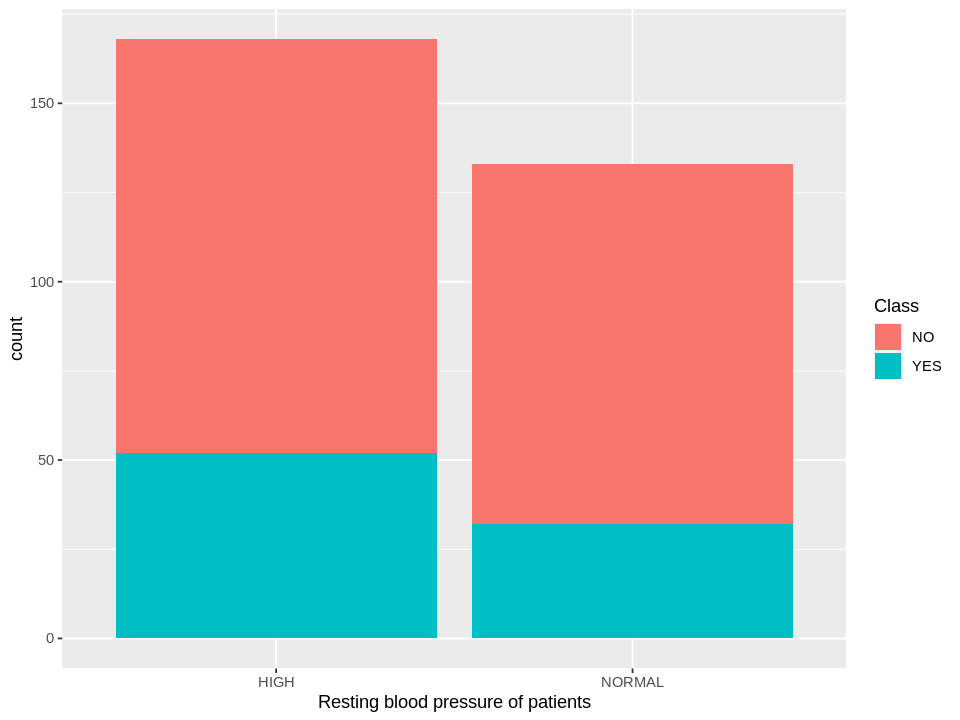

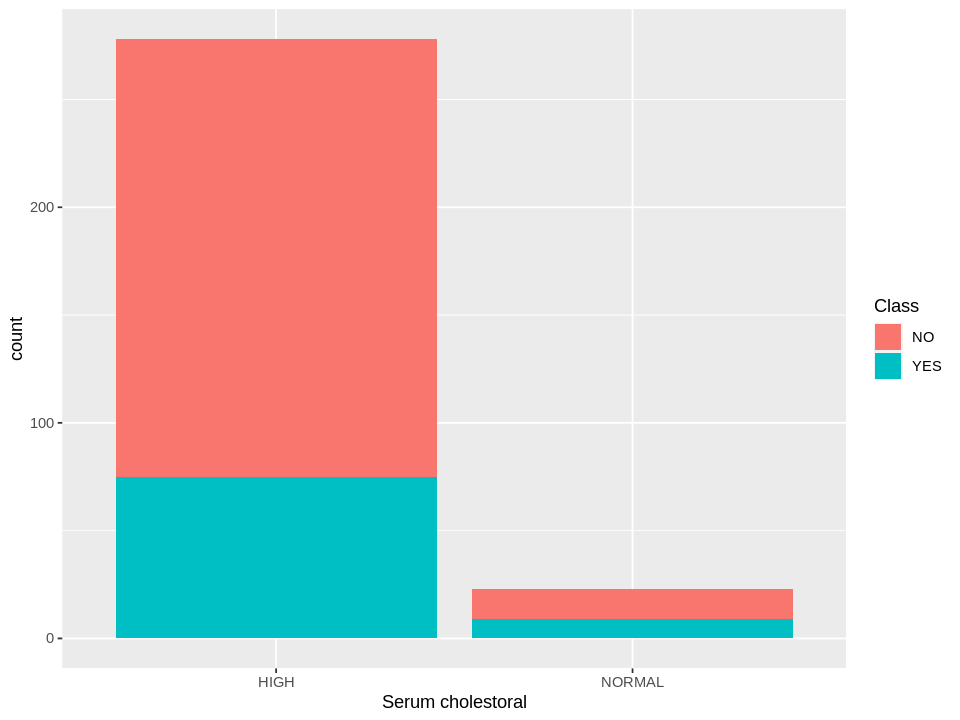

In [156]:
ggplot(heart_data, 
       aes(x = trestbps, fill = Class)) +
  geom_bar() + 
  labs(x = "Resting blood pressure of patients")

ggplot(heart_data, 
       aes(x = chol, fill = Class)) +
  geom_bar() + 
  labs(x = "Serum cholestoral")

## Compute estimates of the parameter

Below, we have created three data frame to summarize the data.The first data frame shows the proportion of the four combinations of presence or absence of high resting blood pressure and presence or absence of heart disease. The second data frame shows the proportion of the four combinations of the presence or absence of high cholesterol and the presence or absence of heart disease.The last data box shows the estimates after taking 1000 replicates of "shuffles" and assuming the null hypothesis is true

In [157]:
#creates a table that displays the count and percentage of each class in the training data
heart_data_n <- heart_data %>%
                      tally()%>%
pull()

heart_data_prop_trestbps <- 
    heart_data %>% 
    group_by(trestbps, Class)%>%
    count() %>% 
    mutate(p = n/heart_data_n)

heart_data_prop_trestbps

heart_data_prop_chol <- 
    heart_data %>% 
    group_by(chol, Class)%>%
    count() %>% 
    mutate(p = n/heart_data_n)

heart_data_prop_chol


null_distribution <- heart_data %>% 
  specify(formula = Class ~ trestbps, success = "YES") %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 1000, type = "permute") %>% 
  calculate(stat = "diff in props", order = c("HIGH", "NORMAL"))

head(null_distribution)

trestbps,Class,n,p
<chr>,<chr>,<int>,<dbl>
HIGH,NO,116,0.3853821
HIGH,YES,52,0.1727575
NORMAL,NO,101,0.3355482
NORMAL,YES,32,0.1063123


chol,Class,n,p
<chr>,<chr>,<int>,<dbl>
HIGH,NO,203,0.67441860
HIGH,YES,75,0.24916944
NORMAL,NO,14,0.04651163
NORMAL,YES,9,0.02990033


replicate,stat
<int>,<dbl>
1,-0.052318296
2,0.082393484
3,-0.106203008
4,-0.025375940
5,0.001566416
6,0.028508772


## Methods

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'thalach' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capture.output(print

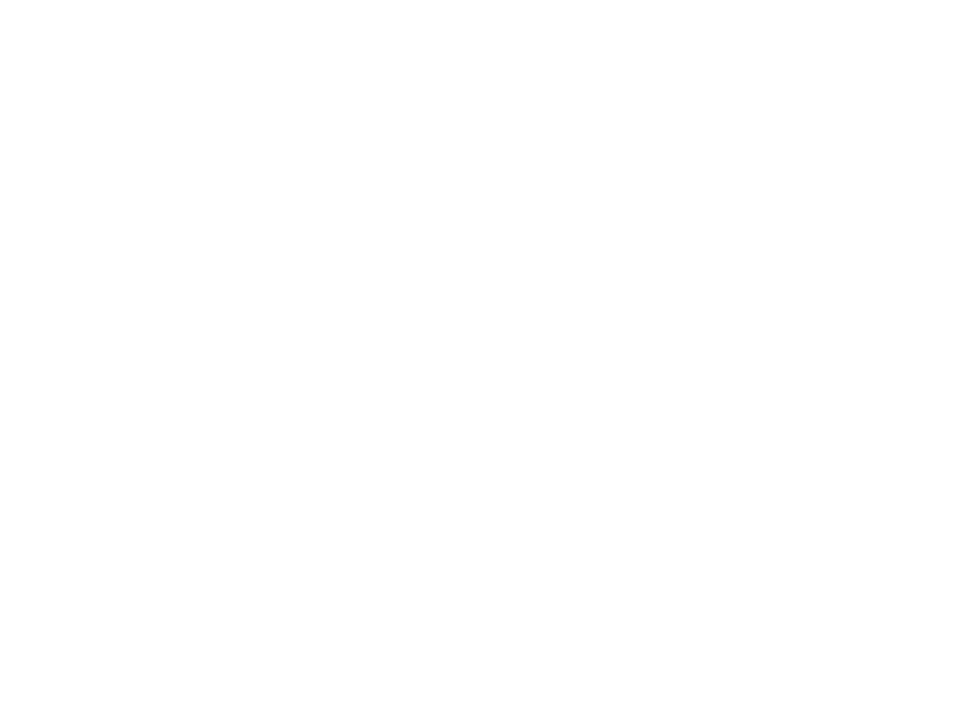

In [153]:
options(repr.plot.width = 8, repr.plot.height = 6)
limited_classes <- filter(heart_data, Class == 0 | Class == 4 | Class == 3)
ggplot(limited_classes, aes(x=trestbps,y=thalach,color=Class,shape=Class)) +
    geom_point() +
    labs(x="Max Heart Rate(Beat/Min)", y= "Blood Pressure(mmHg)", title="Blood Pressure vs Max Heart Rate") +
    theme(text = element_text(size=18))

Given the number of observations in the dataset, we make sure that we have a sample that’s large enough. Also, our analysis process will strictly follow statistical rules and use scientific tools so that our result is unbiased and representative of the population.

The plots are not enough to give a stakeholder because the plots are generated using only a single sample. In other words, although we could obtain a point estimate from the sample, we cannot compute the sampling variation that quantifies the uncertainty about the point estimate. As a result, we cannot be confident enough that our point estimate from the single sample is close to the population parameter.


In order to address this gap, we will generate bootstrap samples based on our original sample, which is our dataset. Next, we will use the infer package in R to compute the sampling distribution of sample proportions. Furthermore, we will conduct a hypothesis test with null hypothesis… with a confidence interval level at 5%.

We expect to find that people with low blood pressure and low cholesterol level would have a lower chance of developing heart disease. Our findings could help raise awareness of the importance of keeping a healthy routine that keeps our blood pressure and cholesterol at a healthy level. Also, since our finding only studies the correlations of the explanatory and response variables, it would be worthy to find out the cause of heart diseases.


Although the distinction among the three classes is not very clear in the example plot above, the distinction between class 0 (no presence of heart disease) and 3/4 (presence of heart disease) is quite clear. By just comparing the two predictors used in the example, it would be a reasonable to predict that a person with low blood pressure (under 120mmHg) and a high max heart rate (over 150 BPM) will likely have some form of heart disease.

### Outcomes and Significance
When using the KNN classifier in our project, every point will have the same weight. One thing that we could consider for future versions of the classifier is, does weighting the points based on how close they are to the new observation increase the accuracy of the classifier?

As outlined in the introduction, with this project we want to determine if the variables we chose act as good predictors for our KNN classifier. Then, using those predictors, we will create an accurate classifier to detect the different classes of heart disease. Should this classifier be accurate, it could have profound effects on the medical world, as we would be able to detect different stages of heart disease using general medical data about an individual. In addition, we could also extend this classifier to attempt to classify other forms of common diseases such as cancer.